In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import joblib
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, f1_score
np.random.seed(2011)

In [2]:
data = pd.read_csv('./data/combined_data.csv')
data.head()

,subreddit,body,author,created_utc,body_length,body_word_count
0,todayilearned,"Ah yes, that's why you guys killed innovent fa...",Pokoirl,1635356074,142,24
1,todayilearned,Then how does a low carb diet work? Same amoun...,laszlo92,1635356072,82,16
2,todayilearned,"In a fun way, Musk's starship being made of st...",barath_s,1635356072,231,38
3,todayilearned,North Korea pre 60s was a very different place...,xPyright,1635356061,174,30
4,todayilearned,Is he making banl on this? He must be paid for...,dirtydownstairs,1635356056,109,22


In [3]:
data.tail(3)

,subreddit,body,author,created_utc,body_length,body_word_count
115184,askscience,His none Sci-Fi stuff is pretty spectacular as...,adamgeekboy,1623850908,160,28
115185,askscience,"If we’re splitting hairs, I have a Samsung ref...",mykepagan,1623850805,596,104
115186,askscience,"When there’s a density gradient, the water at ...",WelchWoman,1623850696,392,73


In [4]:
data.isna().sum()

subreddit          0
body               0
author             0
created_utc        0
body_length        0
body_word_count    0
dtype: int64

In [5]:
data.shape

(115187, 6)

In [6]:
X = data['body']
y = data['subreddit']

In [7]:
# Check baseline model
y.value_counts(normalize = True)

todayilearned    0.511933
askscience       0.488067
Name: subreddit, dtype: float64

In [8]:
# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2011)

## Logistic Regression Modeling
* best model with cvec n_features 3000, stop words top 50
*logreg max iters = 10_000

In [9]:
new_stopwords = joblib.load('./data/add_stopwords.sav')
new_stopwords

['just',
 'like',
 'people',
 'don',
 'think',
 'time',
 'know',
 'gt',
 'did',
 'really',
 'https',
 'good',
 'way',
 'make',
 've',
 'years',
 'actually',
 'thing',
 'say',
 'right',
 'doesn',
 'lot',
 'work',
 'going',
 'sure',
 'want',
 'need',
 'point',
 'things',
 'pretty',
 'better',
 'does',
 'life',
 'mean',
 'isn',
 'com',
 'probably',
 'use',
 'used',
 'yes',
 'll',
 'long',
 'www',
 'different',
 'makes',
 'look',
 'new',
 'reason',
 'amp',
 '10']

In [10]:
# instatiate and fit CountVectorize
cvec= CountVectorizer(max_features = 3000, stop_words = new_stopwords)
cvec.fit(X_train)

CountVectorizer(max_features=3000,
                stop_words=['just', 'like', 'people', 'don', 'think', 'time',
                            'know', 'gt', 'did', 'really', 'https', 'good',
                            'way', 'make', 've', 'years', 'actually', 'thing',
                            'say', 'right', 'doesn', 'lot', 'work', 'going',
                            'sure', 'want', 'need', 'point', 'things', 'pretty', ...])

In [11]:
# transform the corpus
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [12]:
X_train_cvec.shape

(86390, 3000)

In [13]:
cvec.get_feature_names()[50:70]

['ability',
 'able',
 'about',
 'above',
 'abs',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'abstract',
 'abuse',
 'ac',
 'academic',
 'accelerate',
 'accelerating',
 'acceleration',
 'accept',
 'accepted',
 'access',
 'accident']

In [14]:
# model a logistic regression model

logreg = LogisticRegression(max_iter=10_000)
logreg.fit(X_train_cvec, y_train)


LogisticRegression(max_iter=10000)

In [15]:
cross_val_score(logreg, X_test_cvec, y_test, cv = 5 ).mean()

0.8500191306843394

In [16]:
logreg.score(X_train_cvec, y_train), logreg.score(X_test_cvec, y_test)

(0.8788748697765945, 0.8639788866895857)

Model is slightly overfit.

In [17]:
# save model with cvec max_features = 3000 , new_stopwords and logreg
#joblib.dump(logreg, filename = './models/cvec_mf3000_stpwords_logreg.sav' )

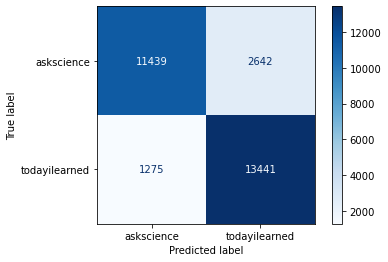

In [18]:
plot_confusion_matrix(logreg, X_test_cvec, y_test, cmap = 'Blues', values_format = 'd');

In [34]:
preds = logreg.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
f1_score_lr = (2 * tp) / (2 * tp + fn + fp)
f1_score_lr

0.8728205461216273

In [20]:
#Calculate specificity; proportion of actual negatives classified correctly
spec = tn/ (tn + fp)
print(f'Specificity {spec}')

Specificity 0.8123712804488318


In [21]:
# calculate sensitivity; proportion of actual positives classified correctly
sens = tp / (tp + fn)
print(f'Sensitivity {sens}')

Sensitivity 0.9133596085892906


In [22]:
print(classification_report(y_test, preds))

               precision    recall  f1-score   support

   askscience       0.90      0.81      0.85     14081
todayilearned       0.84      0.91      0.87     14716

     accuracy                           0.86     28797
    macro avg       0.87      0.86      0.86     28797
 weighted avg       0.87      0.86      0.86     28797



### create pipe for streamlit

In [23]:
pipe = Pipeline([
    ('cv', CountVectorizer(max_features = 3000, stop_words = new_stopwords)),
    ('lr', LogisticRegression(max_iter=10_000))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8788748697765945, 0.8639788866895857)

In [24]:
with open('./models/subreddits_pipe.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(pipe, pickle_out)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115187 entries, 0 to 115186
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   subreddit        115187 non-null  object
 1   body             115187 non-null  object
 2   author           115187 non-null  object
 3   created_utc      115187 non-null  int64 
 4   body_length      115187 non-null  int64 
 5   body_word_count  115187 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 5.3+ MB


## Random Forest Classifier Modeling
* best model with cvec default, stop words = 'english'
* rfc max_depth - None, n_estimator: 500

In [25]:
# instatiate fit, transform CountVectorize
cvec_rfc = CountVectorizer(stop_words = 'english')
cvec_rfc.fit(X_train)
X_train_cvec_rfc = cvec_rfc.transform(X_train)
X_test_cvec_rfc = cvec_rfc.transform(X_test)

In [26]:
# Create a model with RandomForsetClassifier

rfc = RandomForestClassifier()

In [ ]:
#Takes a long time to run
# cross_val_score(rfc, X_train_cvec, y_train).mean()

In [ ]:
#takes a long time to run
# # %%time
# cross_val_score(rfc, X_test_cvec, y_test).mean()

In [ ]:
# # GridSearchCV with random forest

# rfc_params = {
#     'n_estimators' : [500, 600], 
#     'max_depth'    : [None]
    
# }



In [ ]:
takes a long time to run.
# %%time
# gs = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rfc_params, cv = 5, verbose = 1)
# gs.fit(X_train_cvec, y_train)

In [26]:
#load rfc model to evaluate the best rfc model
rfc = joblib.load('./models/cvec_default_rfc_500.sav')

In [27]:
rfc.best_params_

{'max_depth': None, 'n_estimators': 500}

In [28]:
rfc.best_score_

0.8372033800208356

In [29]:
rfc.score(X_train_cvec_rfc, y_train), rfc.score(X_test_cvec_rfc, y_test)

(0.9979858779951383, 0.841129284300448)

Model is extremely overfit.

In [30]:
# print classification report for best rfc model
preds_rfc = rfc.predict(X_test_cvec_rfc)
print(classification_report(y_test, preds_rfc))

               precision    recall  f1-score   support

   askscience       0.86      0.81      0.83     14081
todayilearned       0.83      0.87      0.85     14716

     accuracy                           0.84     28797
    macro avg       0.84      0.84      0.84     28797
 weighted avg       0.84      0.84      0.84     28797



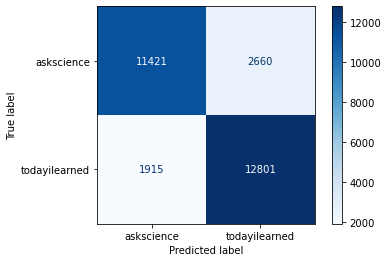

In [31]:
plot_confusion_matrix(rfc, X_test_cvec_rfc, y_test, cmap = 'Blues', values_format = 'd');

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_rfc).ravel()
f1_score_rfc = (2 * tp) / (2 * tp + fn + fp)
f1_score_rfc

0.8483944726115916

In [ ]:
#write save model cvec:defult, rfc: max_depth None, n_estimators: 500
#joblib.dump(gs, '/models/cvec_default_rfc_500.sav')

## Support Vector Machines Modeling
* best model with cvec n_features 3000, stop words top 50
*svm - c=1, degree 2, kernel rbf, gamma :scale

In [ ]:
# %%time
# # Instatiate SVM
# svc  = SVC(C = 1,
#            degree = 2,
#            kernel = 'rbf',
#            gamma = 'scale'
# )

# # fit on training data
# svc.fit(X_train_cvec, y_train)




In [35]:
# load best svm model to evaluate
svm = joblib.load('./models/cvec_stopwords_3000_SVM_2.sav')

In [36]:
# evaluate model

print('Score training data: ', svm.score(X_train_cvec, y_train))
print('Score testing data: ', svm.score(X_test_cvec, y_test))

Score training data:  0.8873364972797777
Score testing data:  0.857485154703615


Model is slightly overfit.

In [37]:
# classification report SVM
preds_svm = svm.predict(X_test_cvec)
print(classification_report(y_test, preds_svm))

               precision    recall  f1-score   support

   askscience       0.89      0.81      0.85     14081
todayilearned       0.83      0.90      0.87     14716

     accuracy                           0.86     28797
    macro avg       0.86      0.86      0.86     28797
 weighted avg       0.86      0.86      0.86     28797



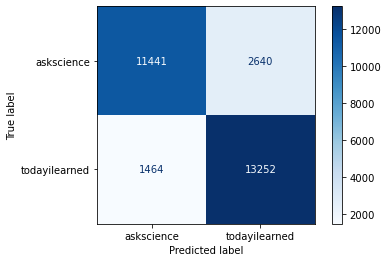

In [38]:
plot_confusion_matrix(svm, X_test_cvec, y_test, cmap = 'Blues', values_format = 'd');

In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_svm).ravel()
f1_score_svm = (2 * tp) / (2 * tp + fn + fp)
f1_score_svm

0.8659174072138003

In [40]:
#write save model cvec:defult,new stop words svm,degree = 2
#joblib.dump(svc, './models/cvec_stopwords_3000_SVM_2.sav')